# Atmospheric composition distribution by CAMS and IASI

### Main goal:
* Compare IASI and CAMS datasets for CO and O<sub>3</sub> (Level 3).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display  

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'CO'

# Define model and API ADS key
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'iasi'
sensor_type = 'L3'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2008-01-01'
end_date = '2018-12-31'

# Define extent
lon_min = -25
lon_max = 45
lat_min = 30
lat_max = 70

# Define resolution (Minimum: 1x1)
lat_res = 1
lon_res = 1

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

The comparison is possible and will start now.
SEARCH PERIOD
- In months: ('2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '

## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(ADS_key, dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')

The file exists, it will not be downloaded again.


In [ ]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 132)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2008-01-01 2008-02-01 ... 2018-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.25 -88.5 -87.75 ... 88.5 89.25 90.0
  * longitude   (longitude) float64 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-19T18:23 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [ ]:
model_levels_df = CAMS_137_levels()
model_levels_df

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [ ]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

In [ ]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

RESULTS
For 2008-01:
IASI_METOPA_L3_CO_COLUMN_200801_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_200801_ULB-LATMOS_V20151001.0.nc is not available.
IASI_METOPC_L3_CO_COLUMN_200801_ULB-LATMOS_V20151001.0.nc is not available.
For 2008-02:
IASI_METOPA_L3_CO_COLUMN_200802_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_200802_ULB-LATMOS_V20151001.0.nc is not available.
IASI_METOPC_L3_CO_COLUMN_200802_ULB-LATMOS_V20151001.0.nc is not available.
For 2008-03:
IASI_METOPA_L3_CO_COLUMN_200803_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_200803_ULB-LATMOS_V20151001.0.nc is not available.
IASI_METOPC_L3_CO_COLUMN_200803_ULB-LATMOS_V20151001.0.nc is not available.
For 2008-04:
IASI_METOPA_L3_CO_COLUMN_200804_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_200804_ULB-LATMOS_V20151001.0.nc is not available.
IASI_METOPC_L3_CO_COLUMN_200804_ULB-LATMOS_V20151001.0.nc is not available.
For 2008-05:
IASI_METOPA_L3_CO_COLUM

In [ ]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates, lat_res, lon_res)
sensor_ds

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 132)
Coordinates:
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 2008-01-01 2008-02-01 ... 2018-12-01
Data variables:
    sensor_column   (time, longitude, latitude) float32 nan 0.01837 ... nan nan
    COgridNIGHT     (time, longitude, latitude) float32 nan nan ... 0.03059 nan
    ErrorgridDAY    (time, longitude, latitude) float32 nan 0.002764 ... nan nan
    ErrorgridNIGHT  (time, longitude, latitude) float32 nan nan ... 0.00268 nan
Attributes:
    units:    mol m-2

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [ ]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 132)
Coordinates:
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 2008-01-01 2008-02-01 ... 2018-12-01
Data variables:
    sensor_column   (time, longitude, latitude) float64 nan 1.106e+18 ... nan
    COgridNIGHT     (time, longitude, latitude) float64 nan nan ... nan
    ErrorgridDAY    (time, longitude, latitude) float64 nan 1.664e+17 ... nan
    ErrorgridNIGHT  (time, longitude, latitude) float64 nan nan ... nan
Attributes:
    units:    molec cm-2

## 4. Match data

In [ ]:
match_table = generate_match_table(sensor_ds, model_ds, bbox,
                                   sensor, component_nom, apply_kernels)
match_table

FOR MONTH: 2008-01
The sensor dataset does not contain data to apply the averaging kernels.
The model dataset does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2008-02
The sensor dataset does not contain data to apply the averaging kernels.
The model dataset does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2008-03
The sensor dataset does not contain data to apply the averaging kernels.
The model dataset does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2008-04
The sensor dataset does not contain data to apply the averaging kernels.
The model dataset does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2008-05
The sensor dataset does not contain data to apply the averaging kernels.
The model dataset does n

,latitude,longitude,time,sensor_column,COgridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column
0,29.5,-25.5,2008-01-01,1.946493e+18,1.965548e+18,1.278131e+16,1.376741e+16,1.852151e+18
1,29.5,-24.5,2008-01-01,1.939168e+18,1.933659e+18,1.479310e+16,1.525139e+16,1.852151e+18
2,29.5,-23.5,2008-01-01,1.930707e+18,2.005423e+18,1.592404e+16,1.792176e+16,1.841896e+18
3,29.5,-22.5,2008-01-01,1.935818e+18,1.935605e+18,1.551402e+16,1.757771e+16,1.840537e+18
4,29.5,-21.5,2008-01-01,1.916482e+18,1.930527e+18,1.660244e+16,1.559824e+16,1.841927e+18
...,...,...,...,...,...,...,...,...
2906,69.5,40.5,2018-12-01,NaN,1.921614e+18,NaN,1.525013e+16,1.854134e+18
2907,69.5,41.5,2018-12-01,NaN,1.906463e+18,NaN,1.578483e+16,1.854617e+18
2908,69.5,42.5,2018-12-01,NaN,1.916512e+18,NaN,1.559833e+16,1.861970e+18
2909,69.5,43.5,2018-12-01,NaN,1.899962e+18,NaN,1.580246e+16,1.863306e+18


## 5. Merge data and calculate difference

In [ ]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, sensor, apply_kernels)
merge_table

sensor_column   COgridNIGHT  ErrorgridDAY  \
latitude longitude time                                                    
29.5     -25.5     2008-01-01   1.946493e+18  1.965548e+18  1.278131e+16   
                   2008-02-01   2.001237e+18  2.079572e+18  1.100384e+16   
                   2008-03-01   2.166826e+18  2.151523e+18  1.292650e+16   
                   2008-04-01   2.146177e+18  2.118955e+18  1.313052e+16   
                   2008-05-01   2.148598e+18  2.094093e+18  9.005940e+15   
...                                      ...           ...           ...   
69.5      44.5     2018-08-01   2.186746e+18  2.514986e+18  1.537175e+16   
                   2018-09-01   2.081204e+18  2.146136e+18  1.564999e+16   
                   2018-10-01   1.777659e+18  1.802608e+18  1.254558e+16   
                   2018-11-01   1.833557e+18  1.898569e+18  2.100564e+16   
                   2018-12-01            NaN  1.933372e+18           NaN   

                               ErrorgridNIGHT  model_column    difference  
latitude longitude time                                                    
29.5     -25.5     2008-01-01    1.376741e+16  1.852151e+18  9.434255e+16  
                   2008-02-01    1.216846e+16  1.956946e+18  4.429096e+16  
                   2008-03-01    1.498953e+16  2.022276e+18  1.445508e+17  
                   2008-04-01    1.461355e+16  1.950990e+18  1.951872e+17  
                   2008-05-01    1.120157e+16  1.910184e+18  2.384139e+17  
...                                       ...           ...           ...  
69.5      44.5     2018-08-01    4.136852e+16  1.760810e+18  4.259364e+17  
                   2018-09-01    2.139920e+16  1.870026e+18  2.111775e+17  
                   2018-10-01    1.383406e+16  1.662053e+18  1.156055e+17  
                   2018-11-01    1.677698e+16  1.722418e+18  1.111395e+17  
                   2018-12-01    1.411014e+16  1.864251e+18           NaN  

[384252 rows x 6 columns]

In [ ]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,sensor_column,COgridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column,difference
count,3.824440e+05,3.753580e+05,3.824440e+05,3.753580e+05,3.842520e+05,3.824440e+05
mean,1.906076e+18,1.926160e+18,1.303770e+16,1.956736e+16,1.817561e+18,8.882637e+16
std,2.406790e+17,2.595949e+17,1.002963e+16,1.620932e+16,2.315091e+17,1.580605e+17
min,9.557126e+17,1.048458e+18,1.727555e+15,3.714445e+15,1.088954e+18,-7.915772e+18
25%,1.734903e+18,1.743643e+18,7.326282e+15,1.197159e+16,1.640984e+18,6.823807e+15
50%,1.886822e+18,1.900472e+18,1.112858e+16,1.568410e+16,1.796078e+18,1.060104e+17
75%,2.077221e+18,2.106698e+18,1.558340e+16,2.174038e+16,1.990492e+18,1.937784e+17
max,4.948694e+18,5.094231e+18,3.796624e+17,4.844820e+17,1.183464e+19,1.282934e+18


## 6. Show comparison plots

### Select plot dates

In [ ]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2008-01' '2008-02' '2008-03' '2008-04' '2008-05' '2008-06' '2008-07'
 '2008-08' '2008-09' '2008-10' '2008-11' '2008-12' '2009-01' '2009-02'
 '2009-03' '2009-04' '2009-05' '2009-06' '2009-07' '2009-08' '2009-09'
 '2009-10' '2009-11' '2009-12' '2010-01' '2010-02' '2010-03' '2010-04'
 '2010-05' '2010-06' '2010-07' '2010-08' '2010-09' '2010-10' '2010-11'
 '2010-12' '2011-01' '2011-02' '2011-03' '2011-04' '2011-05' '2011-06'
 '2011-07' '2011-08' '2011-09' '2011-10' '2011-11' '2011-12' '2012-01'
 '2012-02' '2012-03' '2012-04' '2012-05' '2012-06' '2012-07' '2012-08'
 '2012-09' '2012-10' '2012-11' '2012-12' '2013-01' '2013-02' '2013-03'
 '2013-04' '2013-05' '2013-06' '2013-07' '2013-08' '2013-09' '2013-10'
 '2013-11' '2013-12' '2014-01' '2014-02' '2014-03' '2014-04' '2014-05'
 '2014-06' '2014-07' '2014-08' '2014-09' '2014-10' '2014-11' '2014-12'
 '2015-01' '2015-02' '2015-03' '2015-04' '2015-05' '2015-06' '2015-07'
 '2015-08' '2015-09' '2015-1

### Select plot extent

In [ ]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-25, 30), (45, 70))


### Compare CAMS and IASI total columns

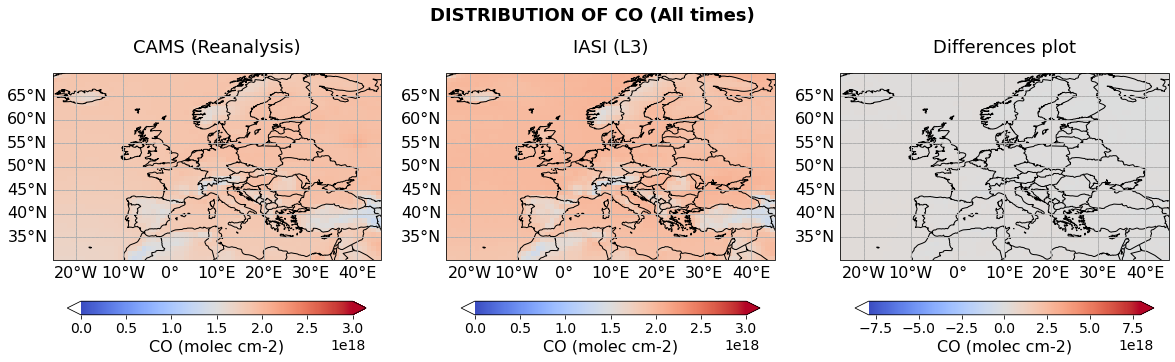

In [ ]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'aggregated'

# Choose range (original, equal or manual)
range_type = 'manual'
vmin_manual = 0
vmax_manual = 3*10**18

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale =  'coolwarm'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.98, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

sensor_column  \
lat_search lon_search latitude longitude time                        
50         15         49.5     14.5      2008-01-01   2.036513e+18   
                                         2008-02-01   1.995097e+18   
                                         2008-03-01   2.154884e+18   
                                         2008-04-01   2.277062e+18   
                                         2008-05-01   2.080821e+18   
...                                                            ...   
20         30         29.5     29.5      2018-08-01   1.871477e+18   
                                         2018-09-01   1.805133e+18   
                                         2018-10-01   1.628315e+18   
                                         2018-11-01   1.636762e+18   
                                         2018-12-01   1.724764e+18   

                                                      COgridNIGHT  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2008-01-01  1.901450e+18   
                                         2008-02-01  2.126184e+18   
                                         2008-03-01  2.261944e+18   
                                         2008-04-01  2.266122e+18   
                                         2008-05-01  2.233820e+18   
...                                                           ...   
20         30         29.5     29.5      2018-08-01  2.035642e+18   
                                         2018-09-01  1.883688e+18   
                                         2018-10-01  1.595197e+18   
                                         2018-11-01  1.595012e+18   
                                         2018-12-01  1.682525e+18   

                                                     ErrorgridDAY  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2008-01-01  2.569851e+16   
                                         2008-02-01  1.306474e+16   
                                         2008-03-01  1.496175e+16   
                                         2008-04-01  1.078202e+16   
                                         2008-05-01  7.891306e+15   
...                                                           ...   
20         30         29.5     29.5      2018-08-01  2.848549e+15   
                                         2018-09-01  3.477670e+15   
                                         2018-10-01  3.888007e+15   
                                         2018-11-01  4.281047e+15   
                                         2018-12-01  5.642812e+15   

                                                     ErrorgridNIGHT  \
lat_search lon_search latitude longitude time                         
50         15         49.5     14.5      2008-01-01    2.712808e+16   
                                         2008-02-01    1.861978e+16   
                                         2008-03-01    2.101280e+16   
                                         2008-04-01    1.661079e+16   
                                         2008-05-01    2.397498e+16   
...                                                             ...   
20         30         29.5     29.5      2018-08-01    1.092550e+16   
                                         2018-09-01    1.182194e+16   
                                         2018-10-01    1.272092e+16   
                                         2018-11-01    1.279499e+16   
                                         2018-12-01    1.603687e+16   

                                                     model_column  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2008-01-01  2.068100e+18   
                                         2008-02-01  2.125096e+18   
                                         2008-03-01  2.137460e+18   
                                         2008-04-01  2.224911e+18   
        

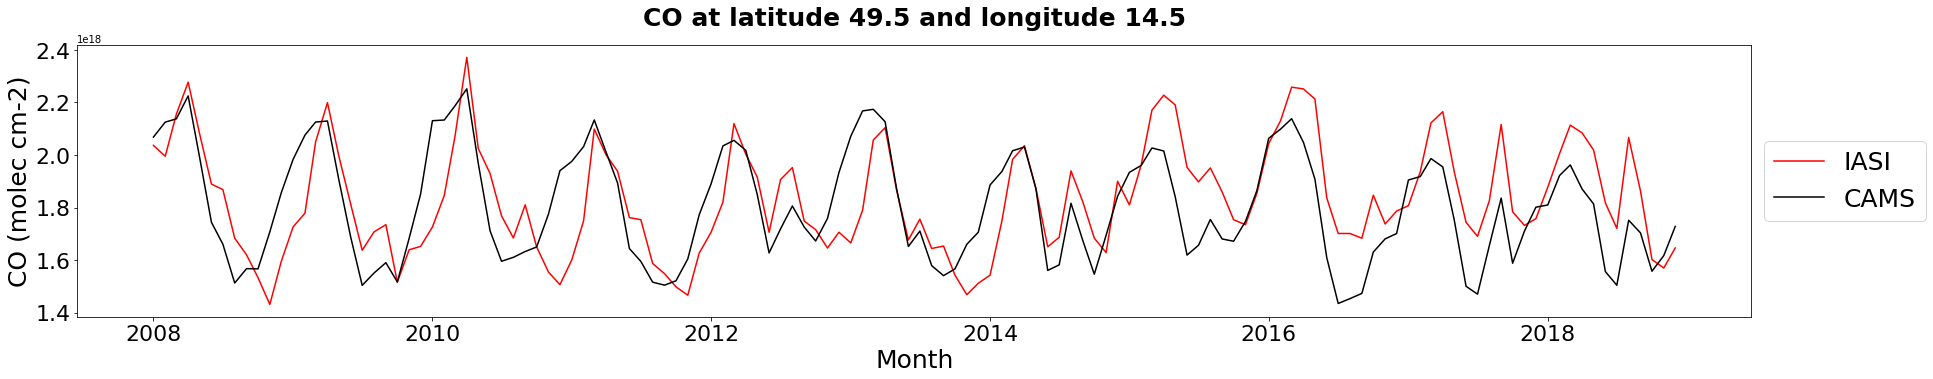

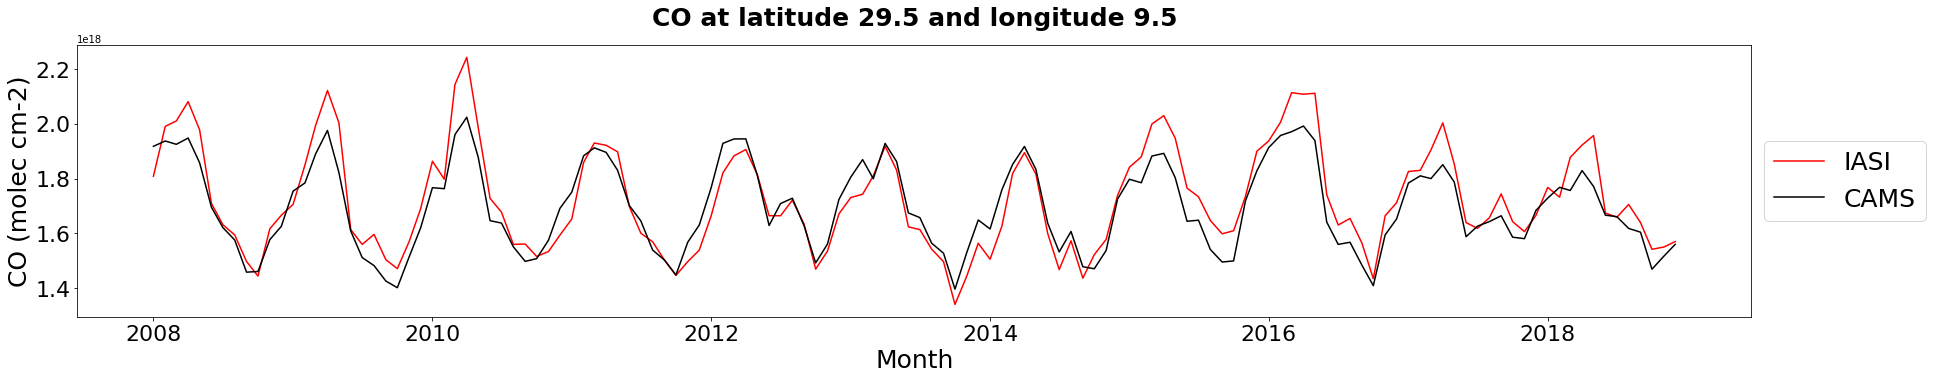

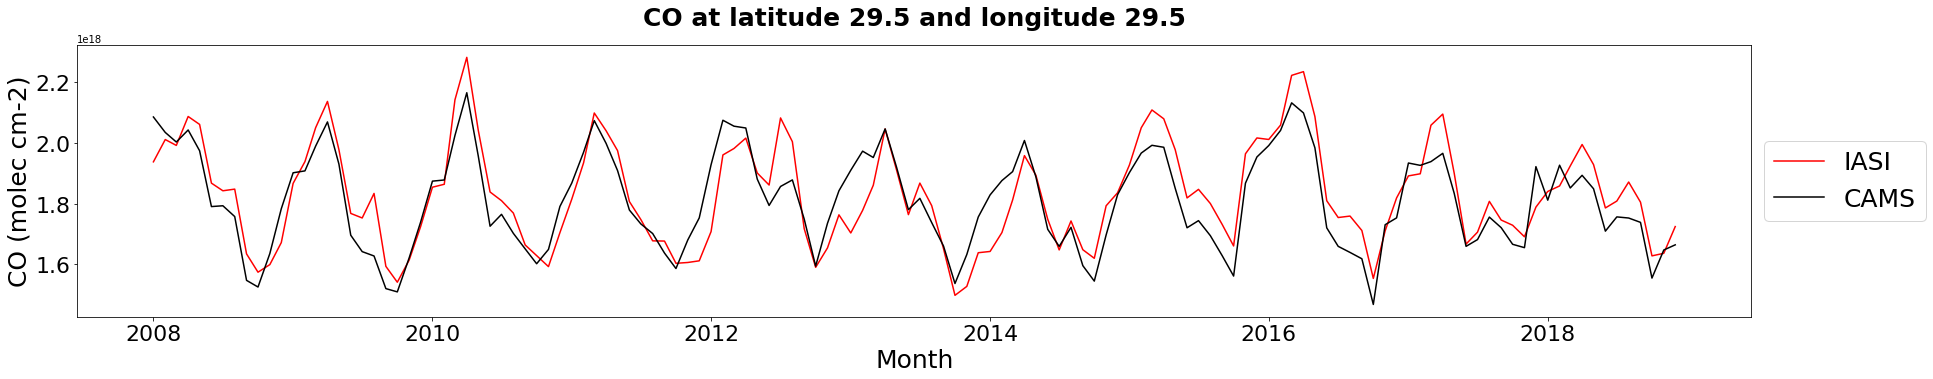

In [ ]:
coords_search_list = (50, 15,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: CO_model = CO_sensor * 0.75 + (3.98E+17)
Coefficient of determination (R2): 0.60


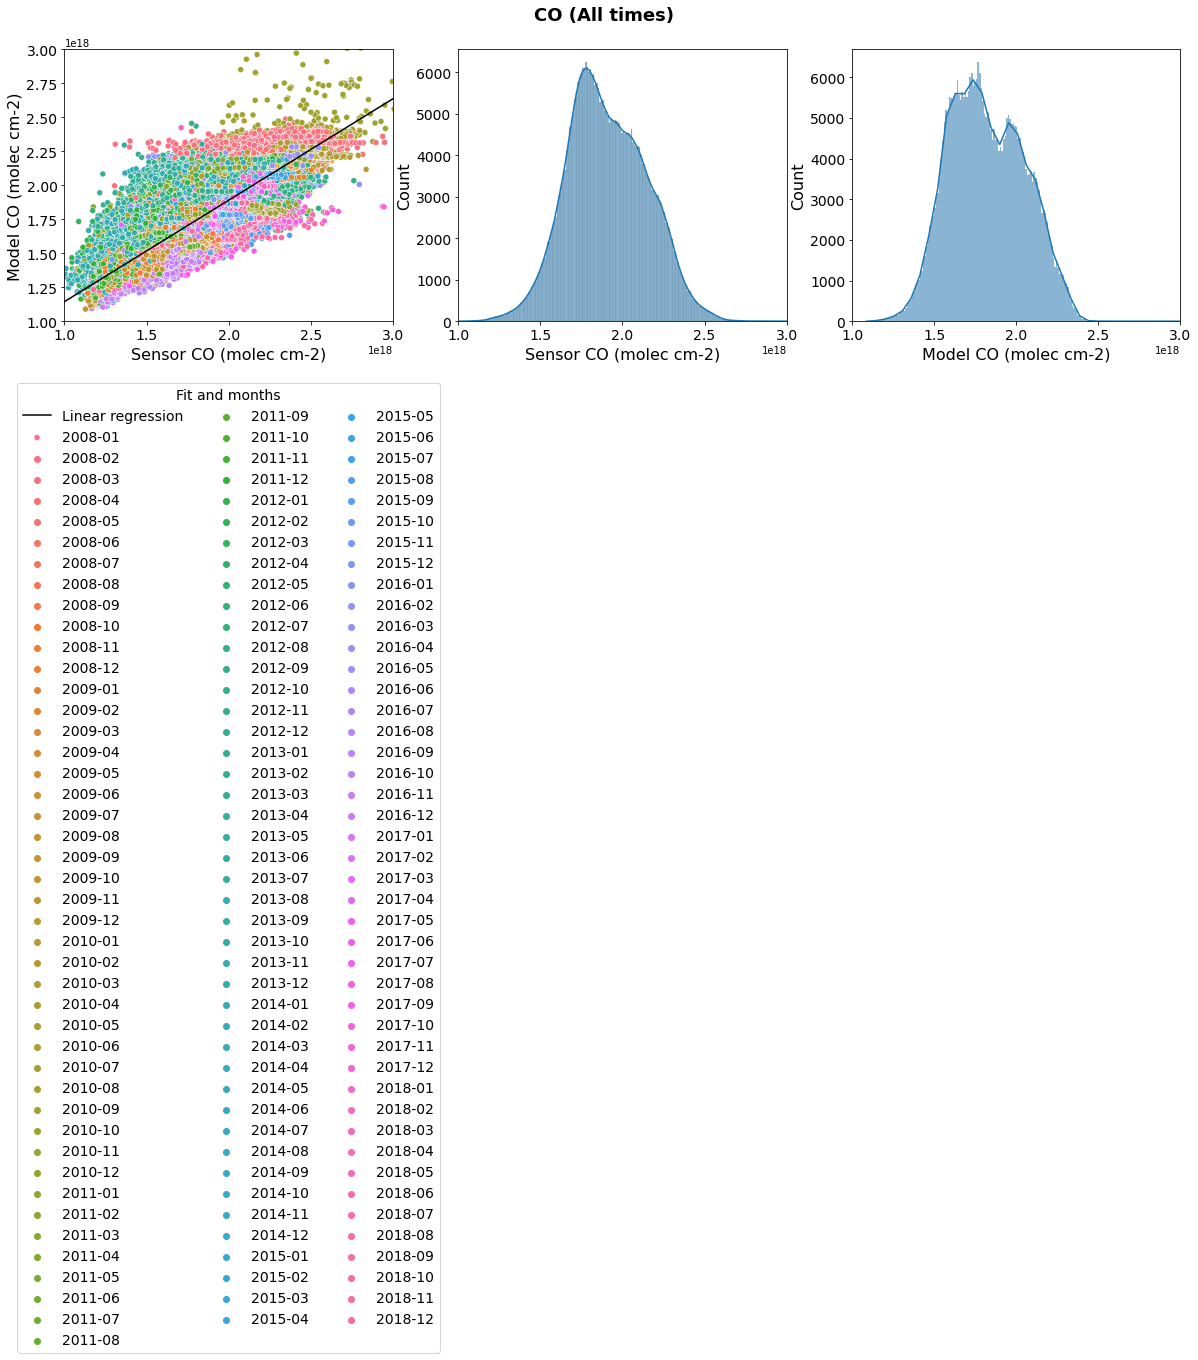

In [ ]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 1*10**18
lim_max = 3*10**18

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [ ]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2008-01-01T00:00:00.000000000, 2008-02-01T00:...","((-25, 30), (45, 70))",0.604844,0.745902,3.982318e+17


## 9. Scatter plots by season

Fit equation: CO_model = CO_sensor * 0.75 + (3.98E+17)
Coefficient of determination (R2): 0.60


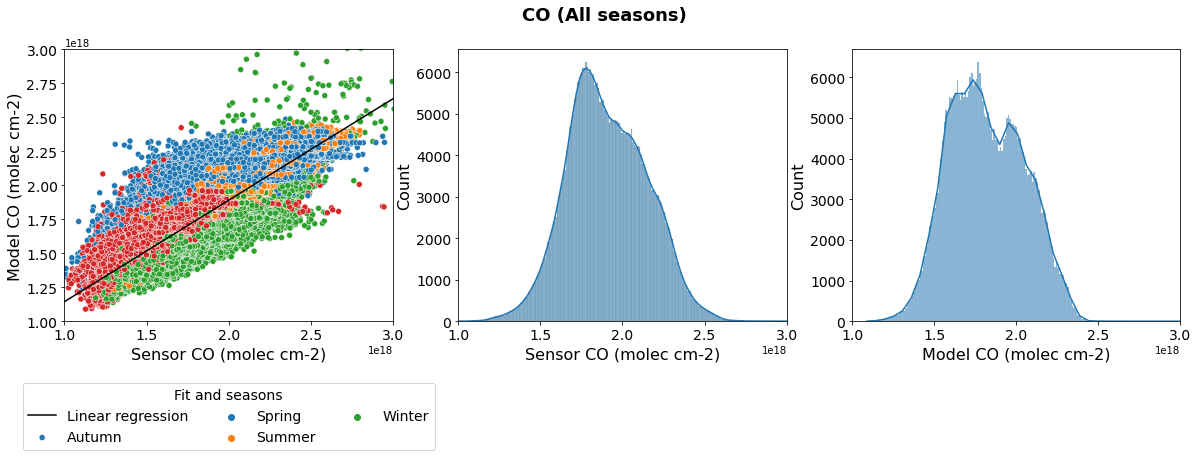

In [ ]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 1*10**18
lim_max = 3*10**18

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [ ]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[Autumn, Spring, Summer, Winter]","((-25, 30), (45, 70))",0.604844,0.745902,3.982318e+17


## 10. Scatter plots by country (Google API required!)

In [ ]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']

lim_min = 1*10**18
lim_max = 3*10**18

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\n\nlim_min = 1*10**18\nlim_max = 3*10**18\n\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [ ]:
#summary